Can we predict the ratio of a game?

Bins for ratings; -3, -2,-1, 0, 1, 2, 3, 4, 5



In [358]:
import pandas as pd # for working with data
import numpy as np # for working with data
import seaborn as sns # for making visualizations
from matplotlib import pyplot as plt # for making visualizations
import sklearn as sk
import datetime as dt
import math

In [359]:
steam_df: pd.DataFrame = pd.read_csv('games_may2024_cleaned.csv')

In [360]:
steam_df.describe()

,AppID,required_age,price,dlc_count,metacritic_score,achievements,recommendations,user_score,score_rank,positive,negative,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,median_playtime_2weeks,peak_ccu,pct_pos_total,num_reviews_total,pct_pos_recent,num_reviews_recent
count,8.364600e+04,83646.000000,83646.000000,83646.000000,83646.000000,83646.000000,8.364600e+04,83646.000000,41.000000,8.364600e+04,8.364600e+04,83646.000000,83646.000000,83646.000000,83646.000000,8.364600e+04,83646.000000,8.364600e+04,83646.000000,83646.000000
mean,1.421850e+06,0.276403,7.492446,0.580542,3.451080,20.702735,1.003478e+03,0.037467,99.121951,1.276726e+03,2.072231e+02,79.663044,3.634364,65.152572,3.744925,9.927115e+01,45.985223,1.345631e+03,5.596191,18.757430
std,7.480058e+05,2.119835,13.094604,14.179160,15.685104,167.839222,2.108173e+04,1.737074,0.748168,3.057663e+04,5.792324e+03,1018.506902,74.621737,933.278070,82.321592,5.914524e+03,40.607112,3.411672e+04,22.911354,1155.763735
min,1.000000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,98.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000
25%,7.922225e+05,0.000000,0.990000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,99.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000
50%,1.373005e+06,0.000000,4.990000,0.000000,0.000000,4.000000,0.000000e+00,0.000000,99.000000,1.100000e+01,3.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,60.000000,1.600000e+01,-1.000000,-1.000000
75%,2.014495e+06,0.000000,9.990000,0.000000,0.000000,20.000000,0.000000e+00,0.000000,100.000000,6.400000e+01,1.900000e+01,0.000000,0.000000,0.000000,0.000000,0.000000e+00,84.000000,8.700000e+01,-1.000000,-1.000000
max,2.984570e+06,21.000000,999.980000,3165.000000,97.000000,9821.000000,4.111974e+06,100.000000,100.000000,7.024836e+06,1.029779e+06,95816.000000,6836.000000,110101.000000,9874.000000,1.362469e+06,100.000000,8.071426e+06,100.000000,321958.000000


In [361]:
# Extract release data into separate columns, as well as convert release_date into a DateTime object
steam_df['release_year'] = steam_df['release_date'].apply(lambda y: int((str(y).split('-'))[0]))
steam_df['release_month'] = steam_df['release_date'].apply(lambda m: int((str(m).split('-'))[1]))
steam_df['release_day'] = steam_df['release_date'].apply(lambda d: int((str(d).split('-'))[2]))
steam_df['release_date'] = pd.to_datetime(steam_df['release_date'], format='%Y-%m-%d')

# Get current age of game
steam_df["current_age"] = dt.datetime.now() - steam_df['release_date']

In [362]:
steam_df['total_review_count'] = steam_df['positive'] + steam_df['negative']
steam_df = steam_df[steam_df['total_review_count'] >= 10]

steam_df['positive_review_percentage'] = (steam_df['positive'] / steam_df['total_review_count']) * 100.0
steam_df = steam_df[steam_df['positive_review_percentage'].isna() == False]

In [363]:
# Calculate Rating based on Steam rating standards
def calculate_steam_rating(num_reviews: int, prp: float) -> str:
    match num_reviews:
        case num_reviews if num_reviews <= 49:
            match prp:
                case prp if 0 <= prp <= 19.0:
                    return 'negative'
                case prp if  29.0 <= prp <= 39.0:
                    return 'mostly_negative'
                case prp if 40.0 <= prp <= 69.0:
                    return 'mixed'
                case prp if 70.0 <= prp <= 79.0:
                    return 'mostly_positive'
                case prp if 80.0 <= prp <= 100.0:
                    return 'positive'
        case num_reviews if 50 >= num_reviews <= 499:
            match prp:
                case prp if 0 <= prp <= 19.0:
                    return 'very_negative'
                case prp if  29.0 <= prp <= 39.0:
                    return 'mostly_negative'
                case prp if 40.0 <= prp <= 69.0:
                    return 'mixed'
                case prp if 70.0 <= prp <= 79.0:
                    return 'mostly_positive'
                case prp if 80.0 <= prp <= 100.0:
                    return 'very_positive'
        case num_reviews if 500 <= num_reviews <= 100_000_000:
            match prp:
                case prp if 0.0 <= prp <= 19.0:
                    return 'overwhelmingly_negative'
                case prp if  29.0 <= prp <= 39.0:
                    return 'mostly_negative'
                case prp if 40.0 <= prp <= 69.0:
                    return 'mixed'
                case prp if 70.0 <= prp <= 79.0:
                    return 'mostly_positive'
                case prp if 80.0 <= prp <= 94.0:
                    return 'very_positive'
                case prp if 95.0 <= prp <= 100.0:
                    return 'overwhelmingly_positive'

In [364]:
steam_df['steam_review'] = steam_df.apply(lambda x: calculate_steam_rating(x['total_review_count'], x['positive_review_percentage']), axis=1)


<Axes: xlabel='steam_review', ylabel='count'>

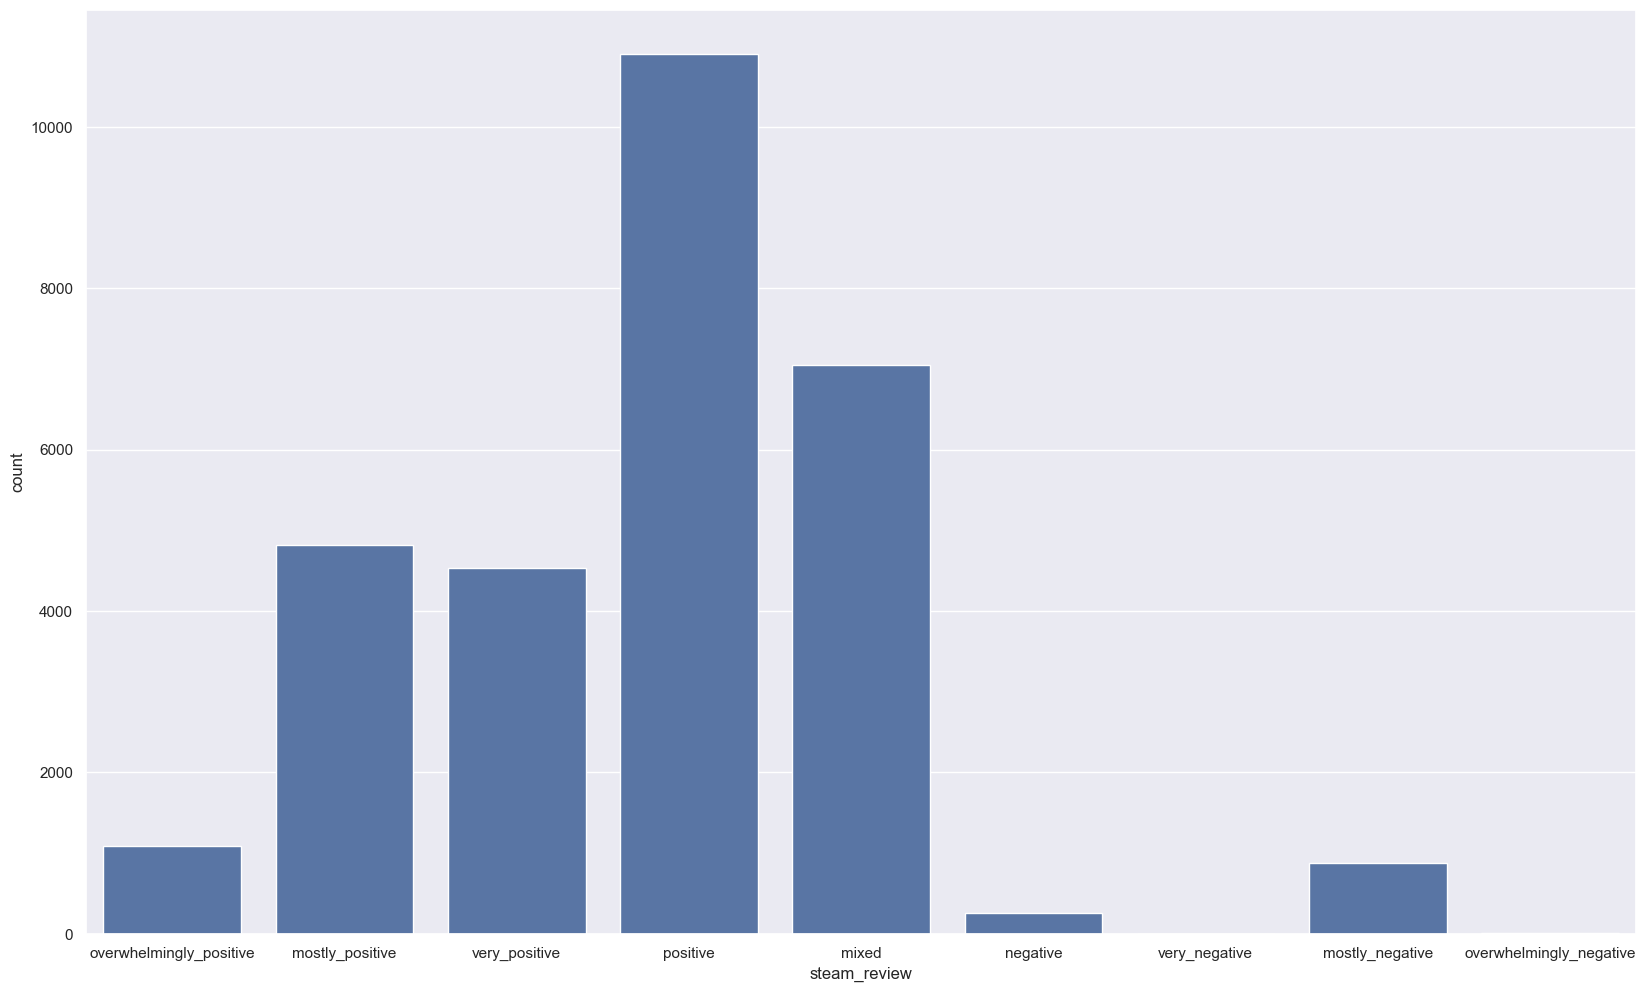

In [365]:
review_order = ['overwhelmingly_positive', 'mostly_positive', 'very_positive', 'positive', 'mixed', 'negative', 'very_negative', 'mostly_negative', 'overwhelmingly_negative']
sns.countplot(data=steam_df, x='steam_review', order=review_order)


In [366]:
# Convert steam_reviews to ints
steam_df = pd.get_dummies(steam_df,  columns = ['steam_review'])


In [367]:
X = steam_df.drop(['price'], axis=1)
y = steam_df['price']

In [368]:
from sklearn.model_selection import train_test_split

In [369]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [370]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((38612, 60), (9654, 60), (38612,), (9654,))

In [371]:
from sklearn import tree

In [372]:
model = tree.DecisionTreeClassifier()

In [373]:
#model.fit(X_train, y_train)